In [1]:
#from proxmin import algorithms as pa, proximal as pp
import logging
from functools import partial

import numpy as np

from proxmin import algorithms, operators

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

plogger = logging.getLogger("proxmin")
plogger.setLevel(logging.INFO)

In [2]:
def f(x,y):
    """Shifted parabola"""
    return (x-1)**2 + y**2

def grad_fx(x,y):
    """Gradient of f wrt x"""
    return 2*x - 2

def grad_fy(x,y):
    """Gradient of f wrt y"""
    return 2*y

def grad_f(xy):
    """Gradient of f"""
    return np.array([grad_fx(xy[0],xy[1]),grad_fy(xy[0],xy[1])])

def prox_circle(xy, step):
    """Projection onto circle"""
    center = np.array([0,0])
    dxy = xy - center
    radius = 0.5
    # exclude interior of circle
    #if (dxy**2).sum() < radius**2:
    # exclude everything other than perimeter of circle
    if 1:
        phi = np.arctan2(dxy[1], dxy[0])
        return center + radius*np.array([np.cos(phi), np.sin(phi)])
    else:
        return xy

def prox_xline(x, step):
    """Projection onto line in x"""
    if not np.isscalar(x):
        x= x[0]
    if x > 0.5:
        return np.array([0.5])
    else:
        return np.array([x])

def prox_yline(y, step):
    """Projection onto line in y"""
    if not np.isscalar(y):
        y= y[0]
    if y > -0.75:
        return np.array([-0.75])
    else:
        return np.array([y])

def prox_line(xy, step):
    """2D projection onto 2 lines"""
    return np.concatenate((prox_xline(xy[0], step), prox_yline(xy[1], step)))

def prox_lim(xy, step, boundary=None):
    """Proximal projection operator"""
    if boundary == "circle":
        return prox_circle(xy, step)
    if boundary == "line":
        return prox_line(xy, step)
    # default: do nothing
    return xy

def prox_gradf(xy, step):
    """Gradient step"""
    return xy-step*grad_f(xy)

def prox_gradf_lim(xy, step, boundary=None):
    """Forward-backward step: gradient, followed by projection"""
    return prox_lim(prox_gradf(xy,step), step, boundary=boundary)

# for GLMM only: x1 and x2 treated separately
def prox_gradf12(x, step, j=None, Xs=None):
    """1D gradient operatpr for x or y"""
    if j == 0:
        return x - step*grad_fx(Xs[0][0], Xs[1][0])
    if j == 1:
        y = x
        return y - step*grad_fy(Xs[0][0], Xs[1][0])
    raise NotImplementedError

def prox_lim12(xy, step, j=None, Xs=None, boundary=None):
    """1D projection operator"""
    # TODO: split boundary in x1 and x2 and use appropriate operator
    return xy

def steps_f12(j=None, Xs=None):
    """Stepsize for f update given current state of Xs"""
    # Lipschitz const is always 2
    if j==0:
        L = 2
    else:
        L = 2
    slack = 1.
    return slack / L


def plotResults(traj, label, boundary=None):
    print (len(traj), traj[-1])
    import matplotlib.pyplot as plt
    import matplotlib.patches as patches

    lims = -2,2
    x,y = np.meshgrid(np.linspace(lims[0],lims[1],1000), np.linspace(lims[0], lims[1],1000))
    r = f(x,y)
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111,aspect='equal')
    #ax.imshow(r, extent=(lims[0], lims[1], lims[0], lims[1]), cmap='Reds')
    ax.contourf(r, 20, extent=(lims[0], lims[1], lims[0], lims[1]), cmap='Reds')
    traj = np.array(traj)
    #ax.scatter(traj[:,0], traj[:,1], s=4, c=np.arange(1,len(traj)+1), cmap='Blues_r')
    ax.plot(traj[:,0], traj[:,1], 'b.', markersize=4, ls='-')

    if boundary is not None:
        if boundary == "circle":
            circ = patches.Circle((0, 0), radius=0.5, fc="none", ec='k', ls='dashed')
            ax.add_artist(circ)
        if boundary == "line":
            ax.plot(lims, [-0.75, -0.75], 'k--')
            ax.plot([0.5,0.5], lims, 'k--')

    ax.scatter(traj[-1][0], traj[-1][1], marker='x', s=30, c='r')
    ax.text(0.05, 0.95, 'it %d: (%.3f, %.3f)' % (len(traj), traj[-1][0], traj[-1][1]), transform=ax.transAxes, color='k', ha='left', va='top')
    ax.set_title(label)
    fig.show()

INFO:proxmin.algorithms:Completed 2 iterations


2 [ 1.  0.]


/Users/fred/miniconda3/envs/glmm/lib/python3.5/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
INFO:proxmin.algorithms:Completed 2 iterations


2 [ 0.5  -0.75]


INFO:proxmin.algorithms:Completed 2 iterations


2 [ 0.5  -0.75]


INFO:proxmin.algorithms:Completed 21 iterations


22 [ 0.50000095 -0.74999952]


INFO:proxmin.algorithms:Completed 21 iterations


22 [ 0.50000095 -0.74999952]


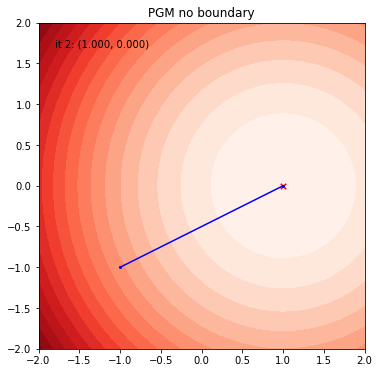

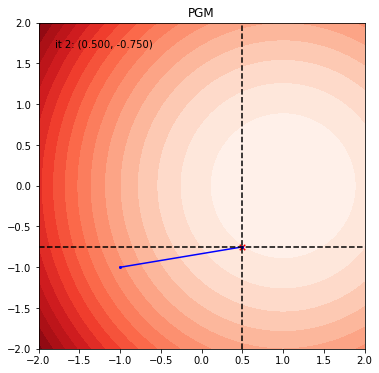

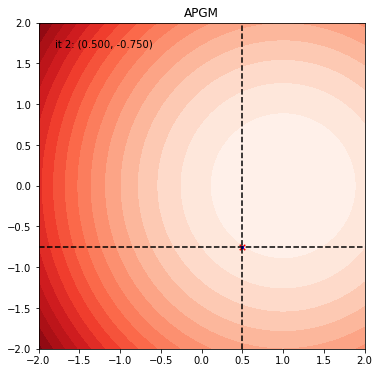

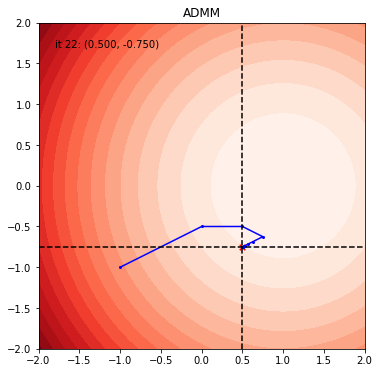

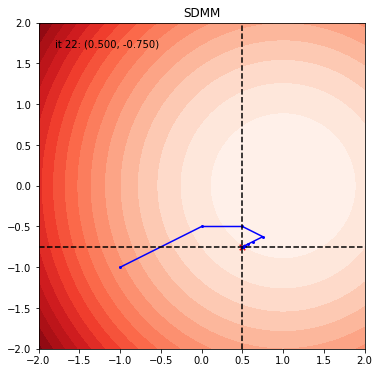

In [3]:
xy = np.array([-1.,-1.])
boundary = "line" # "circle"
max_iter = 100

# step sizes and proximal operators for boundary
step_f = steps_f12()
prox_g = partial(prox_lim, boundary=boundary)
prox_gradf_ = partial(prox_gradf_lim, boundary=boundary)

# PGM without boundary
x, hist = algorithms.pgm(xy, prox_gradf, step_f, max_iter=max_iter, relax=1, traceback=True)
plotResults(hist["X"], "PGM no boundary")

# PGM
x, hist = algorithms.pgm(xy, prox_gradf_, step_f, max_iter=max_iter, relax=1, traceback=True)
plotResults(hist["X"], "PGM", boundary=boundary)

# APGM
x, hist = algorithms.apgm(xy, prox_gradf_, step_f, max_iter=max_iter, traceback=True)
plotResults(hist["X"], "APGM", boundary=boundary)

# ADMM
x, hist = algorithms.admm(xy, prox_gradf, step_f, prox_g, max_iter=max_iter, traceback=True)
plotResults(hist["X"][hist.offset:], "ADMM", boundary=boundary)

# SDMM
M = 2
proxs_g = [prox_g] * M # using same constraint several, i.e. M, times
#steps_g = [step_f * M for j in range(M)] # NOTE: step_g * M !!!!
#Ls = [L] * M
x, hist = algorithms.sdmm(xy, prox_gradf, step_f, proxs_g, max_iter=max_iter, traceback=True)
plotResults(hist["X"][hist.offset:], "SDMM", boundary=boundary)

INFO:proxmin.algorithms:Completed 2 iterations


3 [ 0.5  -0.75]


/Users/fred/miniconda3/envs/glmm/lib/python3.5/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


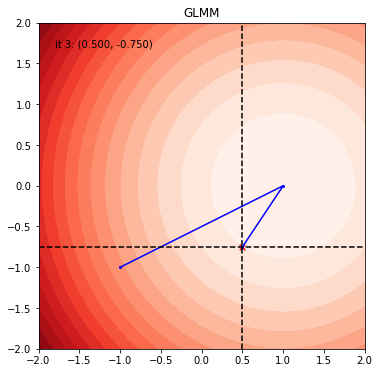

In [17]:
# GLMM
if boundary == "line":
    N = 2
    XY = [np.array([xy[0]]), np.array([xy[1]])]
    M1 = 7
    M2 = 2
    proxs_g = [[prox_xline]*M1, [prox_yline]*M2]
    x, hist = algorithms.glmm(XY, prox_gradf12, steps_f12, proxs_g, max_iter=max_iter, traceback=True)
    traj = np.dstack([hist["X",0], hist["X",1]])[:,0,:]
    plotResults(traj, "GLMM", boundary=boundary)